<a href="https://colab.research.google.com/github/sahil301290/Deep-Learning/blob/master/BERT_news_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import the required libraries**

In [1]:
#Import required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,auc

!pip install transformers
import transformers
from transformers import BertModel, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn  
import torch.nn.functional as F  
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu');

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 12,6

import warnings
warnings.filterwarnings('ignore')

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
!nvidia-smi

Fri May 20 01:03:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
df=pd.read_csv('/content/news_sentiment_data.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,date,articleid,headline,compound_vader_score,sentiment_class
0,0,0,1991-11-14 00:00:00+00:00,wsj_398284048,Banking Bill Negotiators Set Compromise --- Pl...,0.2960,1
1,1,1,1986-06-16 00:00:00+00:00,wsj_397959018,Manager's Journal: Sniffing Out Drug Abusers I...,-0.7003,0
2,2,2,2001-05-24 00:00:00+00:00,wsj_398739166,"Bank of Montreal, Royal Bank Profits Rose in 2...",0.4404,1
3,3,3,1986-10-22 00:00:00+00:00,wsj_397957465,Battle Over Medical Costs Isn't Over,-0.3818,0
4,4,4,2005-12-08 00:00:00+00:00,wsj_399004010,"Dow Falls 45.95, Late GM Surge Stanches Losses",-0.4019,0


In [4]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1','date','articleid','compound_vader_score'], axis=1)
df.head()

,headline,sentiment_class
0,Banking Bill Negotiators Set Compromise --- Pl...,1
1,Manager's Journal: Sniffing Out Drug Abusers I...,0
2,"Bank of Montreal, Royal Bank Profits Rose in 2...",1
3,Battle Over Medical Costs Isn't Over,0
4,"Dow Falls 45.95, Late GM Surge Stanches Losses",0


In [5]:
df.shape

(4846, 2)

In [6]:
Pre_trained_model='bert-base-uncased'

In [7]:
tokenizer=BertTokenizerFast.from_pretrained(Pre_trained_model);

In [8]:
token_lens=[]
for content in df.headline:
    tokens_content=tokenizer.encode(content,max_length=150,truncation=True)
    token_lens.append(len(tokens_content))

Text(0.5, 0, 'Token count')

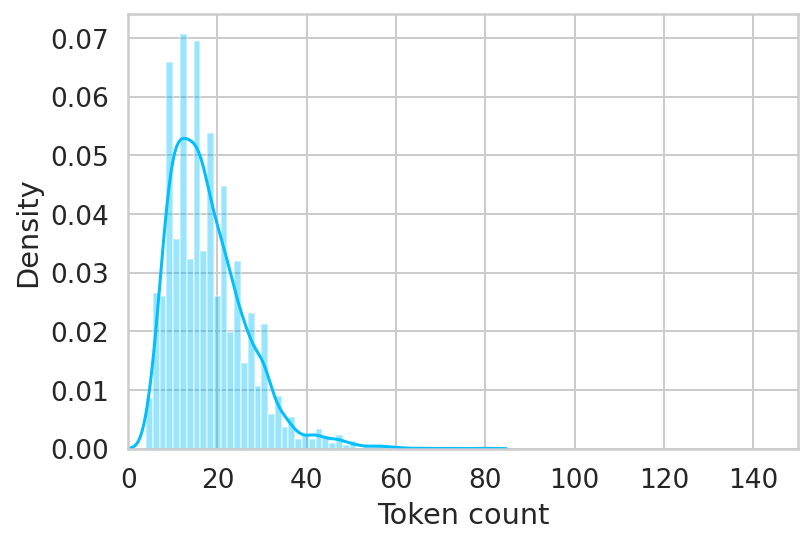

In [9]:
#Plot the tokens
sns.distplot(token_lens)
plt.xlim([0,150])
plt.xlabel('Token count')

In [10]:
Max_length=100

In [11]:
class reviews_headline(Dataset):

    def __init__(self,reviews,targets,tokenizer,max_length):
        self.reviews=reviews
        self.targets=targets
        self.tokenizer=tokenizer
        self.max_length=max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        targets = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            max_length=Max_length,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
           )
        return {
            'review_text':review,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(targets,dtype=torch.long)
        }

In [12]:
df_train,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_valid,df_test = train_test_split(df_test,test_size=0.5,random_state=42)

print('Print the shape of datasets...')
print(f'Training dataset : {df_train.shape}')
print(f'Testing dataset : {df_test.shape}')
print(f'Validation dataset : {df_valid.shape}')

Print the shape of datasets...
Training dataset : (3876, 2)
Testing dataset : (485, 2)
Validation dataset : (485, 2)


In [13]:
batch_size=32
def data_loader(df, tokenizer, max_length, batch):
    ds=reviews_headline(
      reviews=df.headline.to_numpy(),
      targets=df.sentiment_class.to_numpy(),
      tokenizer=tokenizer,
      max_length=Max_length
  )

    return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# Load datasets
train_DataLoader=data_loader(df_train,tokenizer,Max_length,batch_size)
test_DataLoader=data_loader(df_test,tokenizer,Max_length,batch_size)
valid_DataLoader=data_loader(df_valid,tokenizer,Max_length,batch_size)

In [14]:
data=next(iter(train_DataLoader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [15]:
print('Shape of the data keys...')
print(f"Input_ids : {data['input_ids'].shape}")
print(f"Attention_mask : {data['attention_mask'].shape}")
print(f"targets : {data['targets'].shape}")

Shape of the data keys...
Input_ids : torch.Size([32, 100])
Attention_mask : torch.Size([32, 100])
targets : torch.Size([32])


In [16]:
bert_model = BertModel.from_pretrained(Pre_trained_model,return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(Pre_trained_model,return_dict=False)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [18]:
model = SentimentClassifier(len(df.sentiment_class))         #Create an instance / object
model = model.to(device)                              # Move instance to GPU           

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 100])
torch.Size([32, 100])


In [20]:
epochs=5
optimizer=AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_DataLoader)*epochs

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn=nn.CrossEntropyLoss().to(device)

In [21]:
def train(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_observations
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        #Feed data to BERT model
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)     # Clip gradients to avoid exploding gradient problem
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_observations, np.mean(losses)

In [22]:
def eval_model(model, data_loader,device,loss_fn, n_observations):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            # Feed data to BERT model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_observations, np.mean(losses)

In [23]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    train_acc, train_loss = train(
        model,
        train_DataLoader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        valid_DataLoader,
        device,
        loss_fn,
        len(df_valid)
      )
    print(f'Validation  loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 1.5893726343991326 accuracy 0.587203302373581
Validation  loss 0.4230755399912596 accuracy 0.8061855670103093

Epoch 2/5
----------
Train loss 0.2956771866769576 accuracy 0.8898348813209493
Validation  loss 0.25515121512580663 accuracy 0.8969072164948454

Epoch 3/5
----------
Train loss 0.13580993313311798 accuracy 0.9574303405572755
Validation  loss 0.22622074669925496 accuracy 0.9175257731958764

Epoch 4/5
----------
Train loss 0.05533970615704407 accuracy 0.9855521155830752
Validation  loss 0.23198188925744034 accuracy 0.9381443298969072

Epoch 5/5
----------
Train loss 0.02826968488115512 accuracy 0.9935500515995871
Validation  loss 0.25467493012547493 accuracy 0.934020618556701

CPU times: user 12min 56s, sys: 13.6 s, total: 13min 9s
Wall time: 13min 20s


In [25]:
history['train_acc']

[tensor(0.5872, device='cuda:0', dtype=torch.float64),
 tensor(0.8898, device='cuda:0', dtype=torch.float64),
 tensor(0.9574, device='cuda:0', dtype=torch.float64),
 tensor(0.9856, device='cuda:0', dtype=torch.float64),
 tensor(0.9936, device='cuda:0', dtype=torch.float64)]

In [26]:
history['train_acc'][0]

tensor(0.5872, device='cuda:0', dtype=torch.float64)

In [27]:
history['train_acc'][0].item()

0.587203302373581

In [28]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
for i in range(5):
  train_acc.append(history['train_acc'][i].item())
  train_loss.append(history['train_loss'][i].item())
  val_acc.append(history['val_acc'][i].item())
  val_loss.append(history['val_loss'][i].item())
print(train_acc)
print(train_loss)
print(val_acc)
print(val_loss)

[0.587203302373581, 0.8898348813209493, 0.9574303405572755, 0.9855521155830752, 0.9935500515995871]
[1.5893726343991326, 0.2956771866769576, 0.13580993313311798, 0.05533970615704407, 0.02826968488115512]
[0.8061855670103093, 0.8969072164948454, 0.9175257731958764, 0.9381443298969072, 0.934020618556701]
[0.4230755399912596, 0.25515121512580663, 0.22622074669925496, 0.23198188925744034, 0.25467493012547493]


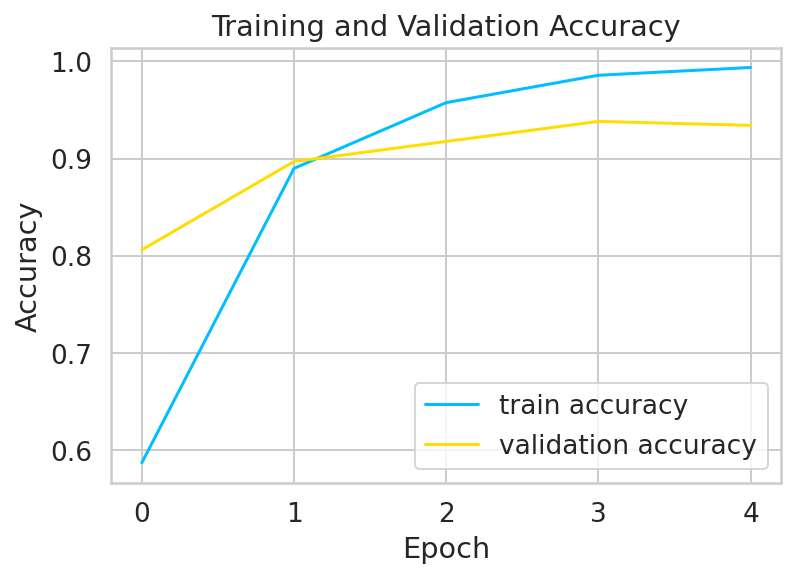

In [29]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

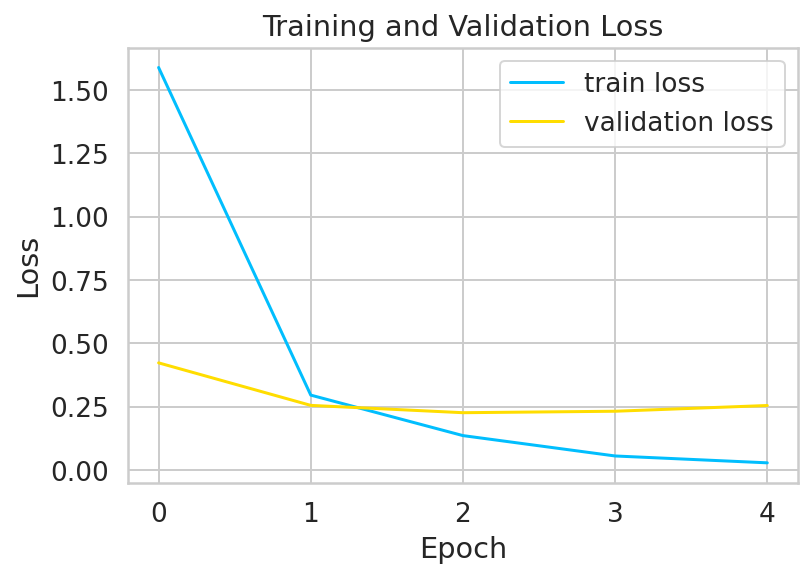

In [30]:
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [31]:
test_acc, _ = eval_model(
  model,
  test_DataLoader,
  device,
  loss_fn,
  len(df_test)
)

In [32]:
test_acc.item()

0.8989690721649485

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_DataLoader
)

In [35]:
df.columns

Index(['headline', 'sentiment_class'], dtype='object')

In [36]:
class_report=classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       218
           1       0.92      0.89      0.91       267

    accuracy                           0.90       485
   macro avg       0.90      0.90      0.90       485
weighted avg       0.90      0.90      0.90       485



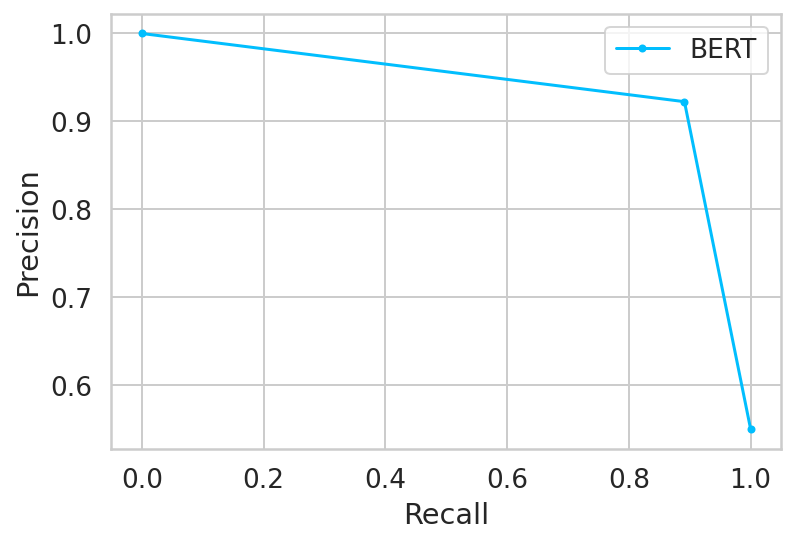

In [37]:
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='BERT')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [38]:
#Calculate AUC_score for PR curve
auc_score = auc(recall, precision)
print('PR AUC_score: %.3f' % auc_score)

PR AUC_score: 0.937


In [39]:
path="./Sentiment_Analysis_Bert.bin"
torch.save(model.state_dict(),path)